## References
* [Julia Documentation](https://docs.julialang.org/en/v1/)

# Make Dataset

In [1]:
using LinearAlgebra
using Distributions
using Random
using Gadfly

In [2]:
# Set parameters
Random.seed!(100)  #  random number generator
K_true = 3;  # the number of categories
D = 2;  # the dimension of the data
N = 500;  # the number of the data
alpha = repeat([1.0], K_true);
mu0 = repeat([0], D);
tSigma = Diagonal(repeat([5.0], D));
Sigma = Diagonal(repeat([0.1], D));

In [3]:
theta_true = rand(Dirichlet(alpha));
Z_count = rand(Multinomial(N, theta_true));
Z_true = [k for k in 1:length(Z_count) for c in 1:Z_count[k]];
mu_true = rand(MvNormal(mu0, tSigma), K_true);  # D x K Array
Y = Array{Float64}(undef, N, D);

In [4]:
# Randomly generate data points
for k in 1:K_true
    mu_true[:, k] += repeat([1.5 * k], D)    
end

for (i, k) in enumerate(Z_true)
    Y[i, :] = rand(MvNormal(mu_true[:, k], Sigma));
end

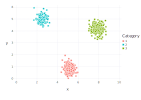

In [5]:
plot(x = Y[:, 1], y = Y[:, 2], colour = [string(z) for z in Z_true],
    Scale.color_discrete_manual("#F8766D", "#00BFC4", "#7CAE00"),
    Guide.colorkey(title = "Category")
)

# Sampling

### Define parameters 

In [6]:
temperatuares = collect(LinRange(0.1, 1.0, 5));
replica_n = length(temperatuares);  # number of replicas
replica_chainID = [i  for i in 1:replica_n];  # replica_chainID[1] = the  chain ID that the first replica uses
K = 3;
niter = 300;

### Initialization

In [7]:
Z = Array{Int16}(undef, replica_n, N);
mu = Array{Float64}(undef, D, K, replica_n);
theta = Array{Float64}(undef, replica_n, K);
accept = zeros(Int16, replica_n, 2);

for replica_id in 1:replica_n
    theta[replica_id, :] = rand(Dirichlet(alpha));
    
    Z_count = rand(Multinomial(N, theta_true));
    Z[replica_id, :] = shuffle([k for k in 1:length(Z_count) for c in 1:Z_count[k]]);
    
    mu[:, :, replica_id] = rand(MvNormal(mu0, tSigma), K);
end

### Define functions

In [8]:
function visualize(Y, Z, mu, replica_id)
    p = plot(
        layer(x = Y[:, 1], y = Y[:, 2], colour = [string(z) for z in Z[replica_id, :]]),
        layer(x = mu[1, :, replica_id], y = mu[2, :, replica_id], color=[colorant"black"]),
        Scale.color_discrete_manual("#F8766D", "#00BFC4", "#7CAE00"),
        Guide.colorkey(title = "Category")
    );
    return p
end

function iteration(replica_index, replica_chainID, temperatuares, K, Z, mu, theta, Y, tSigma, Sigma, alpha, accept)
    # Define functions
    function sample_z(replica_index, replica_chainID, temperatuares, K, Z, mu, theta, Y, tSigma, Sigma)
        replica_id = replica_chainID[replica_index];
        beta = temperatuares[replica_id];

        for i in 1:size(Y)[1]
            vec_prob = Array{Float64}(undef, K)

            for k in 1:K
                diff = Y[i, :] - mu[:, k, replica_id];
                vec_prob[k] = exp(-0.5 * transpose(diff) * inv(Sigma) * diff)^beta * theta[replica_id, k]^beta
            end
            vec_prob /= sum(vec_prob)

            Z[replica_id, i] = (rand(Categorical(vec_prob)))[1]
        end

        return Z
    end


    function sample_theta(replica_index, replica_chainID, temperatuares, K, Z, mu, theta, Y, tSigma, Sigma, alpha)
        replica_id = replica_chainID[replica_index];
        beta = temperatuares[replica_id];

        vec_alpha = zeros(Float64, K)
        for k in 1:K
            count::Int32 = length(findall(Z[replica_id, :] .== k))
            vec_alpha[k] = (alpha[k] + count) * beta
        end
        theta[replica_id, :] = rand(Dirichlet(vec_alpha))

        return theta
    end


    function sample_mu(replica_index, replica_chainID, temperatuares, K, Z, mu, theta, Y, tSigma, Sigma, accept)
        
        replica_id = replica_chainID[replica_index];
        beta = temperatuares[replica_id];

        for k in 1:K
            n = length(findall(Z_true[:] .== k))
            Y_k = sum(Y[findall(Z[replica_id, :] .== k), :], dims = 1)
            sigma_n = inv(tSigma) + n * inv(Sigma)
            mu_n = inv(sigma_n) * (inv(tSigma) * mu0 + inv(Sigma) * transpose(Y_k))
            
            mu_current = mu[:, k, replica_id]
            llk_current = beta * -0.5 * transpose(mu_current - mu_n) * sigma_n * (mu_current - mu_n)
            
            D = size(mu[:, k, replica_id])[1]
            mu_new = (mu_current + rand(MvNormal(repeat([0.0], D), Diagonal(repeat([0.05], D))), 1))[:]
            llk_new = beta * -0.5 * transpose(mu_new - mu_n) * sigma_n * (mu_new - mu_n)

            r = min(0, llk_new[1] - llk_current[1])
            u = log(rand())

            if u < r
                # Accept
                mu[:, k, replica_id] = mu_new;
                accept[replica_index, 1] += 1
            else
                # Reject
                accept[replica_index, 2] += 1
            end
            
            ## Gibbs Sampling
            # mu_new = rand(MvNormal(mu_n[:], inv(sigma_n)), 1);
            # mu[:, k, replica_id] = mu_new;
        end

        return mu
    end
    
    Z = sample_z(replica_index, replica_chainID, temperatuares, K, Z, mu, theta, Y, tSigma, Sigma)
    theta = sample_theta(replica_index, replica_chainID, temperatuares, K, Z, mu, theta, Y, tSigma, Sigma, alpha)
    mu = sample_mu(replica_index, replica_chainID, temperatuares, K, Z, mu, theta, Y, tSigma, Sigma, accept)
    
    return Z, theta, mu, accept
end

iteration (generic function with 1 method)

### Iteration

In [9]:
replica_index = 5
for iter in 1:niter
    Z, theta, mu, accept = iteration(replica_index, replica_chainID, temperatuares, K, Z, mu, theta, Y, tSigma, Sigma, alpha, accept);
end

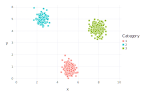

In [10]:
visualize(Y, Z, mu, replica_index)

In [11]:
accept

5×2 Array{Int16,2}:
   0    0
   0    0
   0    0
   0    0
 185  715

In [12]:
mu[:, :, replica_index]

2×3 Array{Float64,2}:
 5.14296   2.49276  7.82626
 0.844104  5.03707  4.17345

In [13]:
mu_true

2×3 Array{Float64,2}:
 5.16203   2.5215   7.94407
 0.819759  4.98328  4.19929